In [1]:

import torch
from PIL import Image
import json
import glob
import os
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy import stats

from torch.utils.data import Dataset, DataLoader  # Import Dataset and DataLoader
import torchvision.transforms as transforms
import torch
import torch.optim as optim
import torch.nn.functional as F

import torchvision.models.segmentation as segmentation


from utility import CityscapeSegTemp, get_min_max, train, evaluate, plot_samples, plot_predictions, plot_metrics

from utility import cityscapes_cmap, plot_class_colors


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_name = torch.cuda.get_device_name(0)  
elif torch.backends.mps.is_available():  # Check for M1 GPU availability
    device = torch.device("mps")  # M1 GPU
    gpu_name = "Apple M1"
else:
    device = torch.device("cpu")
    gpu_name = "CPU"

print(f"Using device: {device}, GPU: {gpu_name}")

Using device: cuda, GPU: NVIDIA RTX A3000 Laptop GPU


In [3]:
temp_min, temp_max = get_min_max('./data')

print(temp_min, temp_max)

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

13.5 44.5


In [4]:
aug = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = CityscapeSegTemp(root_dir ='./data', split = 'train', 
                                 device = device, 
                                 transform = aug, 
                                 temp_scale=(temp_min, temp_max)
                                 )



val_dataset =   CityscapeSegTemp(root_dir = './data', split= 'val', 
                                 device = device, 
                                 transform = aug,
                                 temp_scale=(temp_min, temp_max)
                                 )


batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [5]:
unique_mask_values = set()

for i in range(20):
    _, (mask, _) = val_dataset[i]  # Assuming this is how your dataset returns values
    unique_values = torch.unique(mask).tolist()  # Convert to a list of values
    unique_mask_values.update(unique_values)  # Update the set with new unique values

print(f'Unique mask values in the dataset: {unique_mask_values}')
print(f'Total: {len(unique_mask_values)}')

Unique mask values in the dataset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
Total: 11


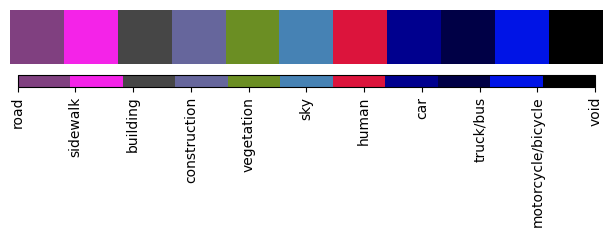

In [6]:
classes = [
            'road', 
           'sidewalk', 
           'building',
           'construction', 
         #   'object', 
           'vegetation', 
        #    'terrain', 
           'sky',
           'human', 
           'car', 
           'truck/bus', 
           'motorcycle/bicycle' ,  
           'void']

plot_class_colors(classes, cityscapes_cmap)

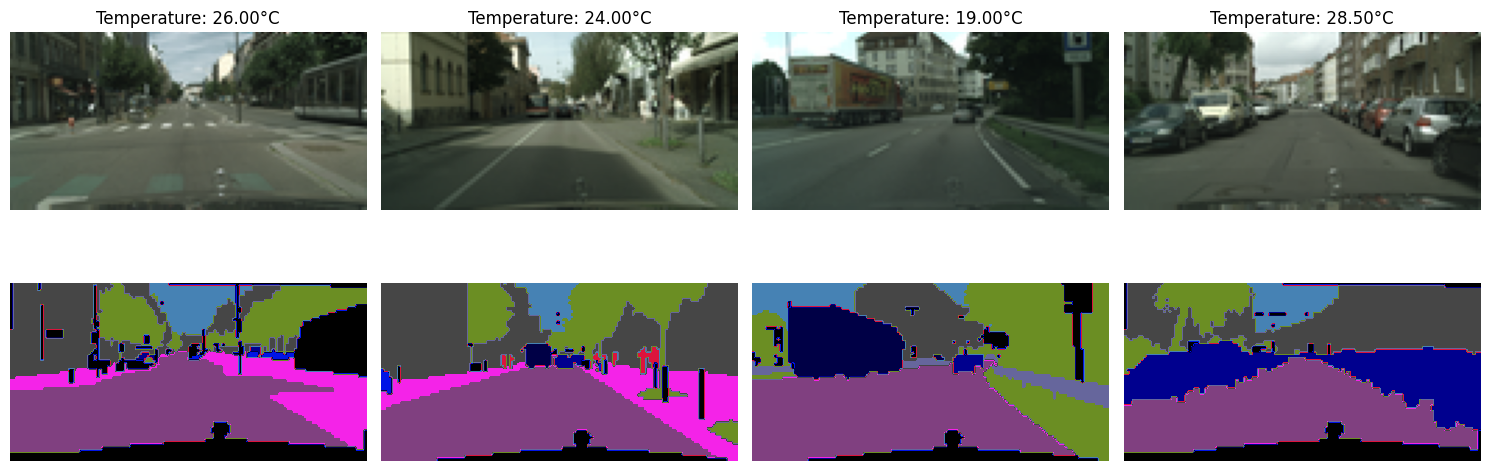

In [7]:
plot_samples(train_loader, unnormalize= True, mean = mean , std = std, temp_scale=(temp_min, temp_max))

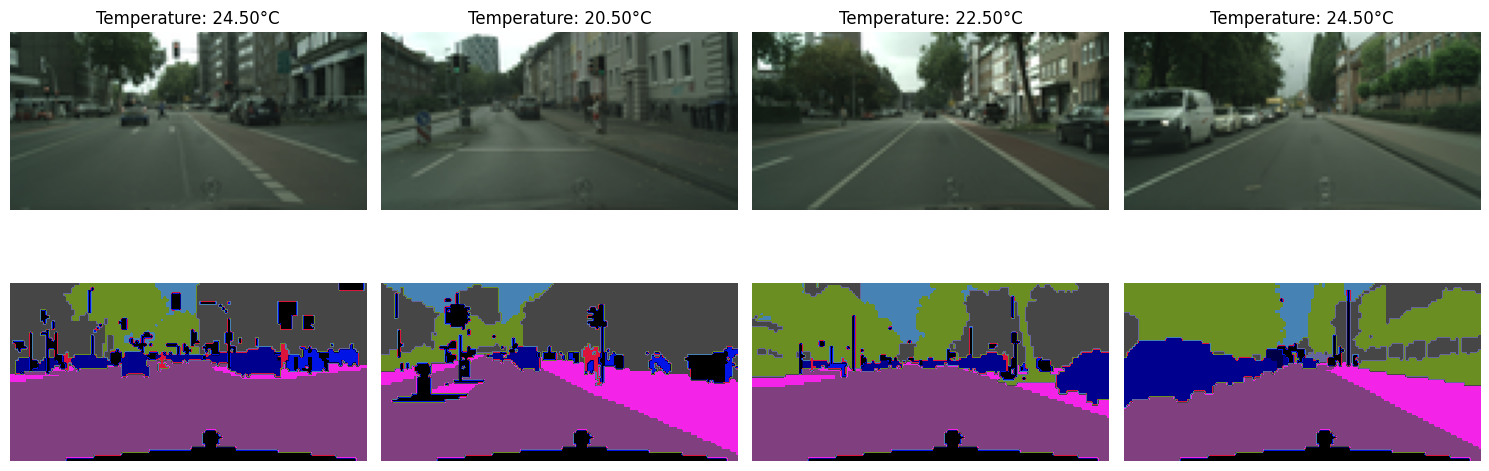

In [8]:
plot_samples(val_loader, unnormalize= True, mean = mean , std = std, temp_scale=(temp_min, temp_max))

In [9]:
from blocks import ResidualBlock, UpsampleBlock, ASPP, Bottleneck, UpsampleMaxPool

class ResidualUNet(nn.Module):
    def __init__(self, num_classes):
        super(ResidualUNet, self).__init__()
        self.encoder1 = ResidualBlock(3, 64)
        self.encoder2 = ResidualBlock(64, 128, stride=2) # 1/2
        self.encoder3 = ResidualBlock(128, 256, stride=2) # 1/4
        self.encoder4 = ResidualBlock(256, 512, stride=2) # 1/8
        self.bridge = ResidualBlock(512, 1024, stride=2) # 1/16

        self.aspp_mask = ASPP(1024, 1024, [6, 12, 18])
        self.aspp_temp = ASPP(1024, 1024, [6, 12, 18])

        self.upsample1 = UpsampleBlock(1024, 512)
        self.upsample2 = UpsampleBlock(512, 256)
        self.upsample3 = UpsampleBlock(256, 128)
        self.upsample4 = UpsampleBlock(128, 64)

        self.mask_output = nn.Conv2d(64, num_classes, kernel_size=1)
        self.temp_output = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(1024, 2048),
            nn.ReLU(True),
            nn.Linear(2048, 1)
        )

        # self.lstm = nn.LSTM(input_size=2048, hidden_size=2048, 
        #                     num_layers=3, batch_first=True)
        
        # self.final_fc = nn.Linear(2048, 1)
        
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        enc5 = self.bridge(enc4)

        aspp_mask = self.aspp_mask(enc5)
        aspp_temp = self.aspp_temp(enc5)

        up1 = self.upsample1(aspp_mask, enc4)
        up2 = self.upsample2(up1, enc3)
        up3 = self.upsample3(up2, enc2)
        up4 = self.upsample4(up3, enc1)

        mask = self.mask_output(up4)
        temp = self.temp_output(aspp_temp) 

        # lstm_out, (hidden, cell) = self.lstm(temp.unsqueeze(1))
        # temp_out = self.final_fc(lstm_out[:, -1, :])

        return mask, temp

In [10]:
num_classes = 11
model = ResidualUNet(num_classes)
model = model.to(device)

total_epoch = 20

log_interval = 20


optimizer = optim.Adam(model.parameters(), lr= 1e-03,  weight_decay = 1e-03)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epoch)


In [11]:
best_val_acc = 0.0

train_loss = []
val_loss = []

train_mask_loss= []
val_mask_loss= []

train_mask_loss= []
val_mask_loss= []

train_temp_loss= []
val_temp_loss= []

train_epoch_iou =[]
val_epoch_iou =[]

for epoch in range(total_epoch):
    train(epoch, model, train_loader, optimizer, log_interval, num_classes, train_loss, train_epoch_iou, train_mask_loss , train_temp_loss)
    
    val_acc = evaluate(model, val_loader, num_classes, val_loss,val_epoch_iou, val_mask_loss,  val_temp_loss )
    scheduler.step()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        model_file = 'best_model.pth'
        torch.save(model.state_dict(), model_file)
        print('\nSaved best model to ' + model_file + '.')

    print()
    

Train Epoch: 0 [0/2975 (0%)]	Loss: 2.600	Mask Loss: 2.546, Temp Loss: 0.053
Train Epoch: 0 [320/2975 (11%)]	Loss: 1.014	Mask Loss: 0.992, Temp Loss: 0.021
Train Epoch: 0 [640/2975 (22%)]	Loss: 0.873	Mask Loss: 0.846, Temp Loss: 0.027
Train Epoch: 0 [960/2975 (32%)]	Loss: 0.821	Mask Loss: 0.798, Temp Loss: 0.024
Train Epoch: 0 [1280/2975 (43%)]	Loss: 0.839	Mask Loss: 0.817, Temp Loss: 0.022
Train Epoch: 0 [1600/2975 (54%)]	Loss: 0.665	Mask Loss: 0.643, Temp Loss: 0.022
Train Epoch: 0 [1920/2975 (65%)]	Loss: 0.731	Mask Loss: 0.720, Temp Loss: 0.011
Train Epoch: 0 [2240/2975 (75%)]	Loss: 0.858	Mask Loss: 0.846, Temp Loss: 0.012
Train Epoch: 0 [2560/2975 (86%)]	Loss: 0.670	Mask Loss: 0.649, Temp Loss: 0.021
Train Epoch: 0 [2880/2975 (97%)]	Loss: 0.604	Mask Loss: 0.592, Temp Loss: 0.012
Train Epoch Loss: 1.013 ------ Mask Loss: 0.842 ---- Temp Loss: 0.171 ---- Mean IOU: 0.341
Valid total loss: 0.816 ------ Mask Loss: 0.785 ---- Temp Loss: 0.031 ---- Mean IOU: 0.350

Saved best model to best

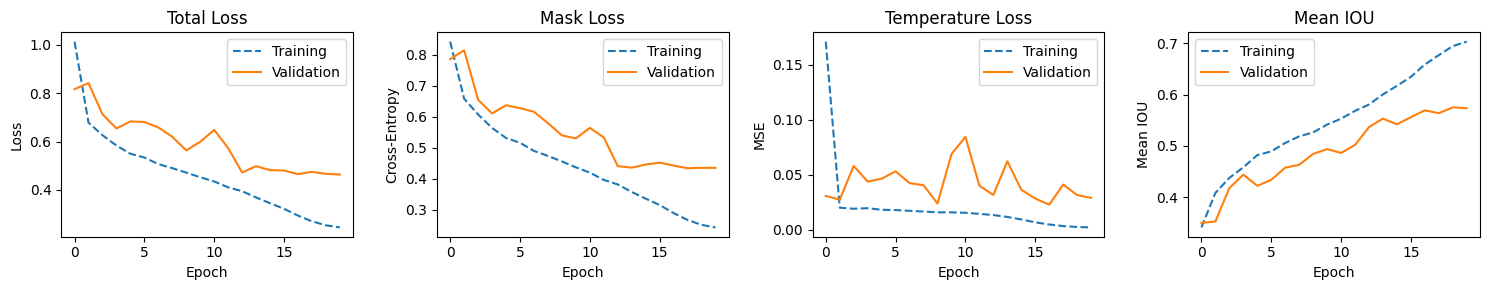

In [12]:
plt.figure(figsize=(15, 3))

plt.subplot(1, 4, 1)
plt.plot(train_loss, label='Training', linestyle = 'dashed' )
plt.plot(val_loss, label='Validation', )
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(train_mask_loss, label='Training',  linestyle = 'dashed')
plt.plot(val_mask_loss, label='Validation')
plt.title('Mask Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy')
plt.legend()


plt.subplot(1, 4, 3)
plt.plot(train_temp_loss, label='Training',  linestyle = 'dashed')
plt.plot(val_temp_loss, label='Validation')
plt.title('Temperature Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()


plt.subplot(1, 4, 4)
plt.plot(train_epoch_iou, label='Training', linestyle = 'dashed')
plt.plot(val_epoch_iou, label='Validation')
plt.title('Mean IOU')
plt.xlabel('Epoch')
plt.ylabel('Mean IOU')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluate Training data 

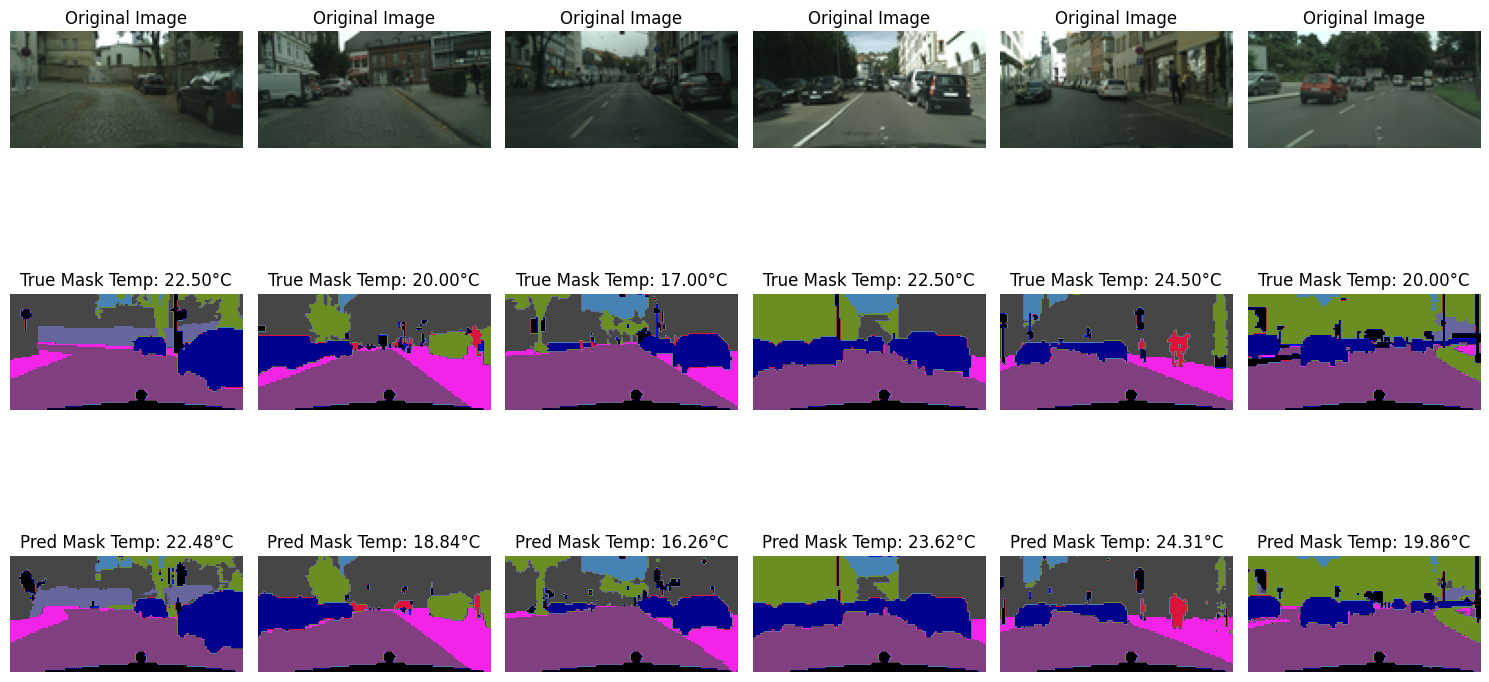

In [13]:
plot_predictions(model, train_loader, device, num_samples=6,  unnormalize= True, mean = mean , std = std, temp_scale=(temp_min, temp_max))

## Evaluate Validation data

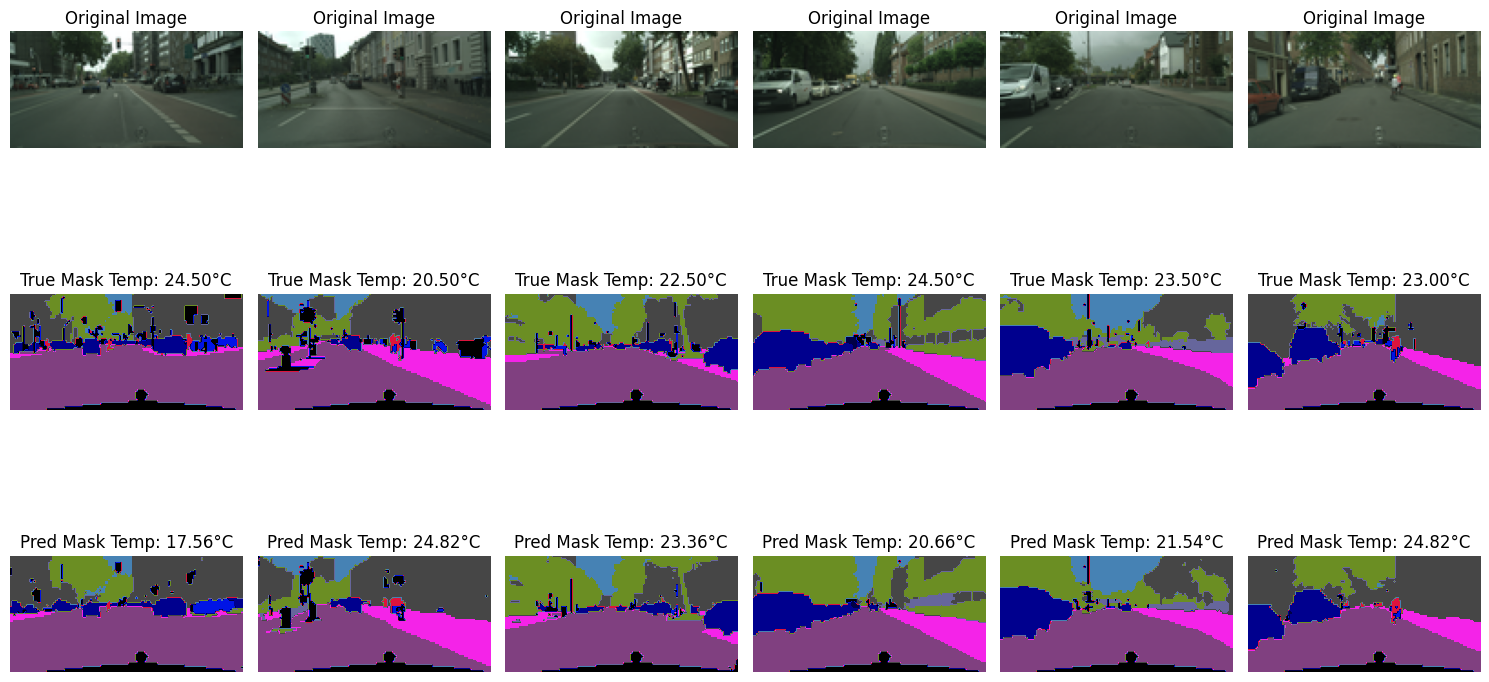

In [14]:
plot_predictions(model, val_loader, device, num_samples=6,  unnormalize= True, mean = mean , std = std, temp_scale=(temp_min, temp_max))

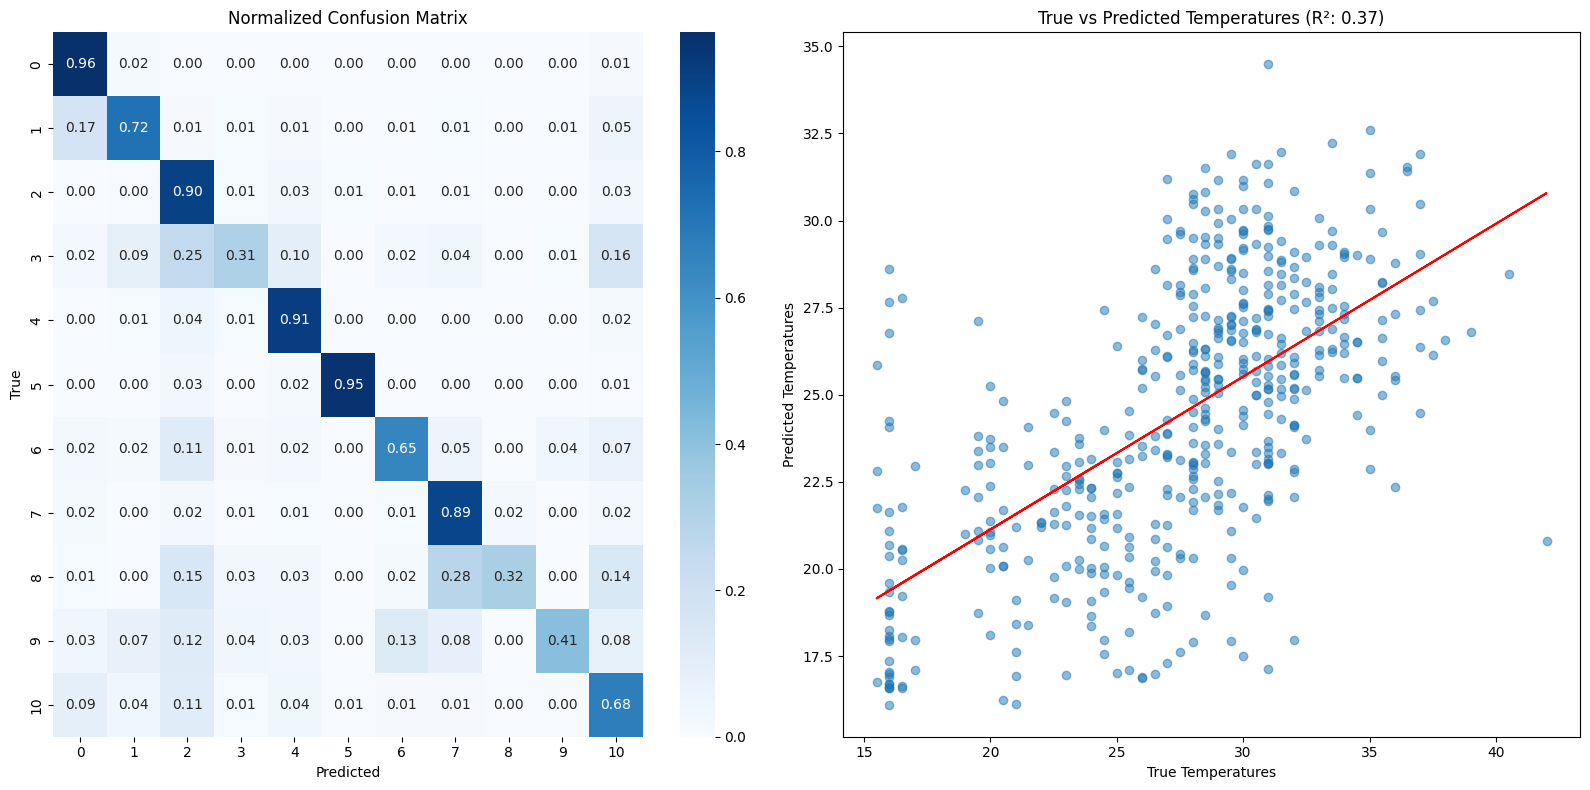

In [15]:
plot_metrics(model, val_loader, device, num_classes, temp_scale=(temp_min, temp_max))

In [16]:
from torch.utils.data import Subset
import random

test_dataset =   CityscapeSegTemp(root_dir = './data', split= 'test', 
                                 device = device, 
                                 transform = aug,
                                 temp_scale=(temp_min, temp_max)
                                 )



num_samples = 100
random_indices = random.sample(range(len(test_dataset)), num_samples)
test_dataset = Subset(test_dataset, random_indices)


test_loader = DataLoader(test_dataset, batch_size=6, shuffle=True)

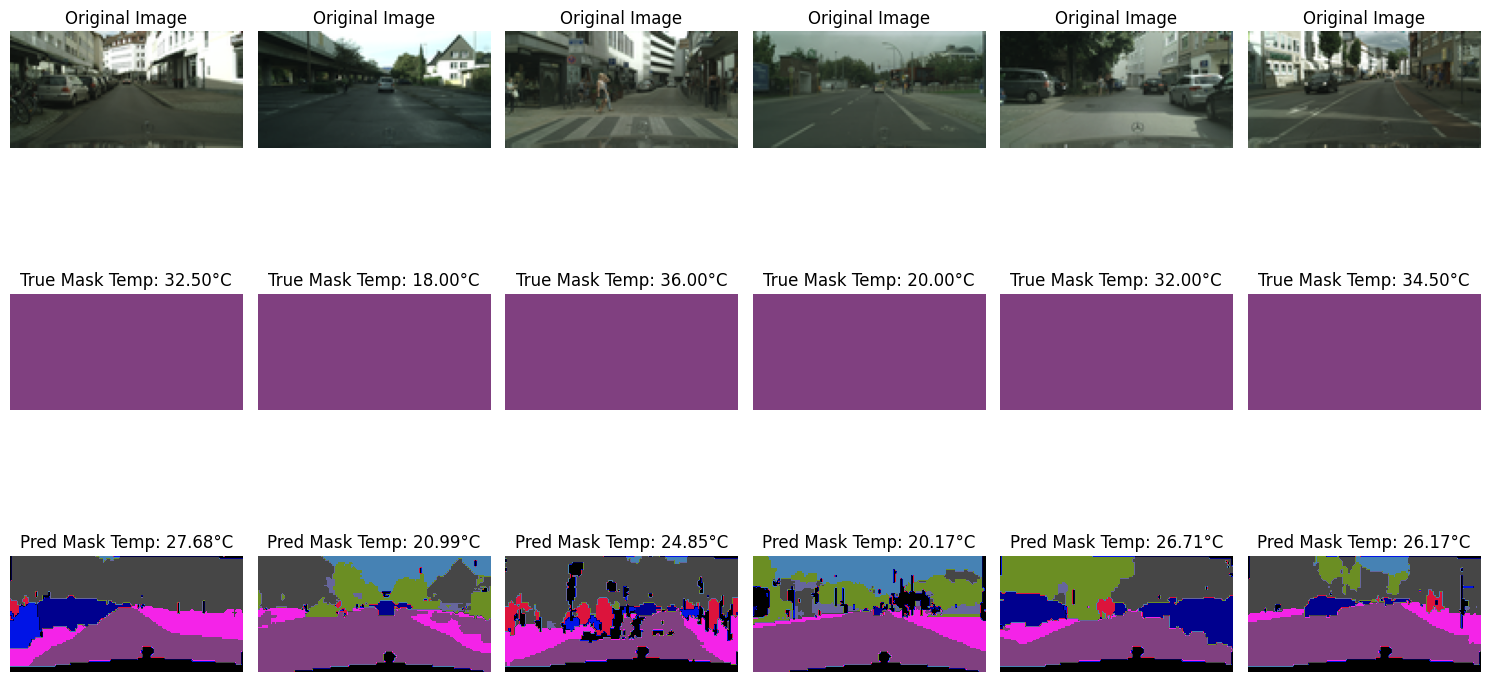

In [17]:
plot_predictions(model, test_loader, device, num_samples=6,  unnormalize= True, mean = mean , std = std, temp_scale=(temp_min, temp_max))